In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import pickle
import seaborn as sns
import skimage.metrics
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from xgboost import DMatrix
import warnings
warnings.simplefilter('ignore')

In [ ]:
#read the test data
df_validate = pd.read_csv('/content/drive/MyDrive/CREASE-2D/Crease_2400_126/test_dataset_2400_126.csv')
df_validate.shape

(2797200, 10)

In [ ]:
#load the trained_xgboost model
loaded_model = xgb.Booster(model_file='/content/drive/MyDrive/CREASE-2D/Crease_2400_126/xgbmodel_2400_126.json')

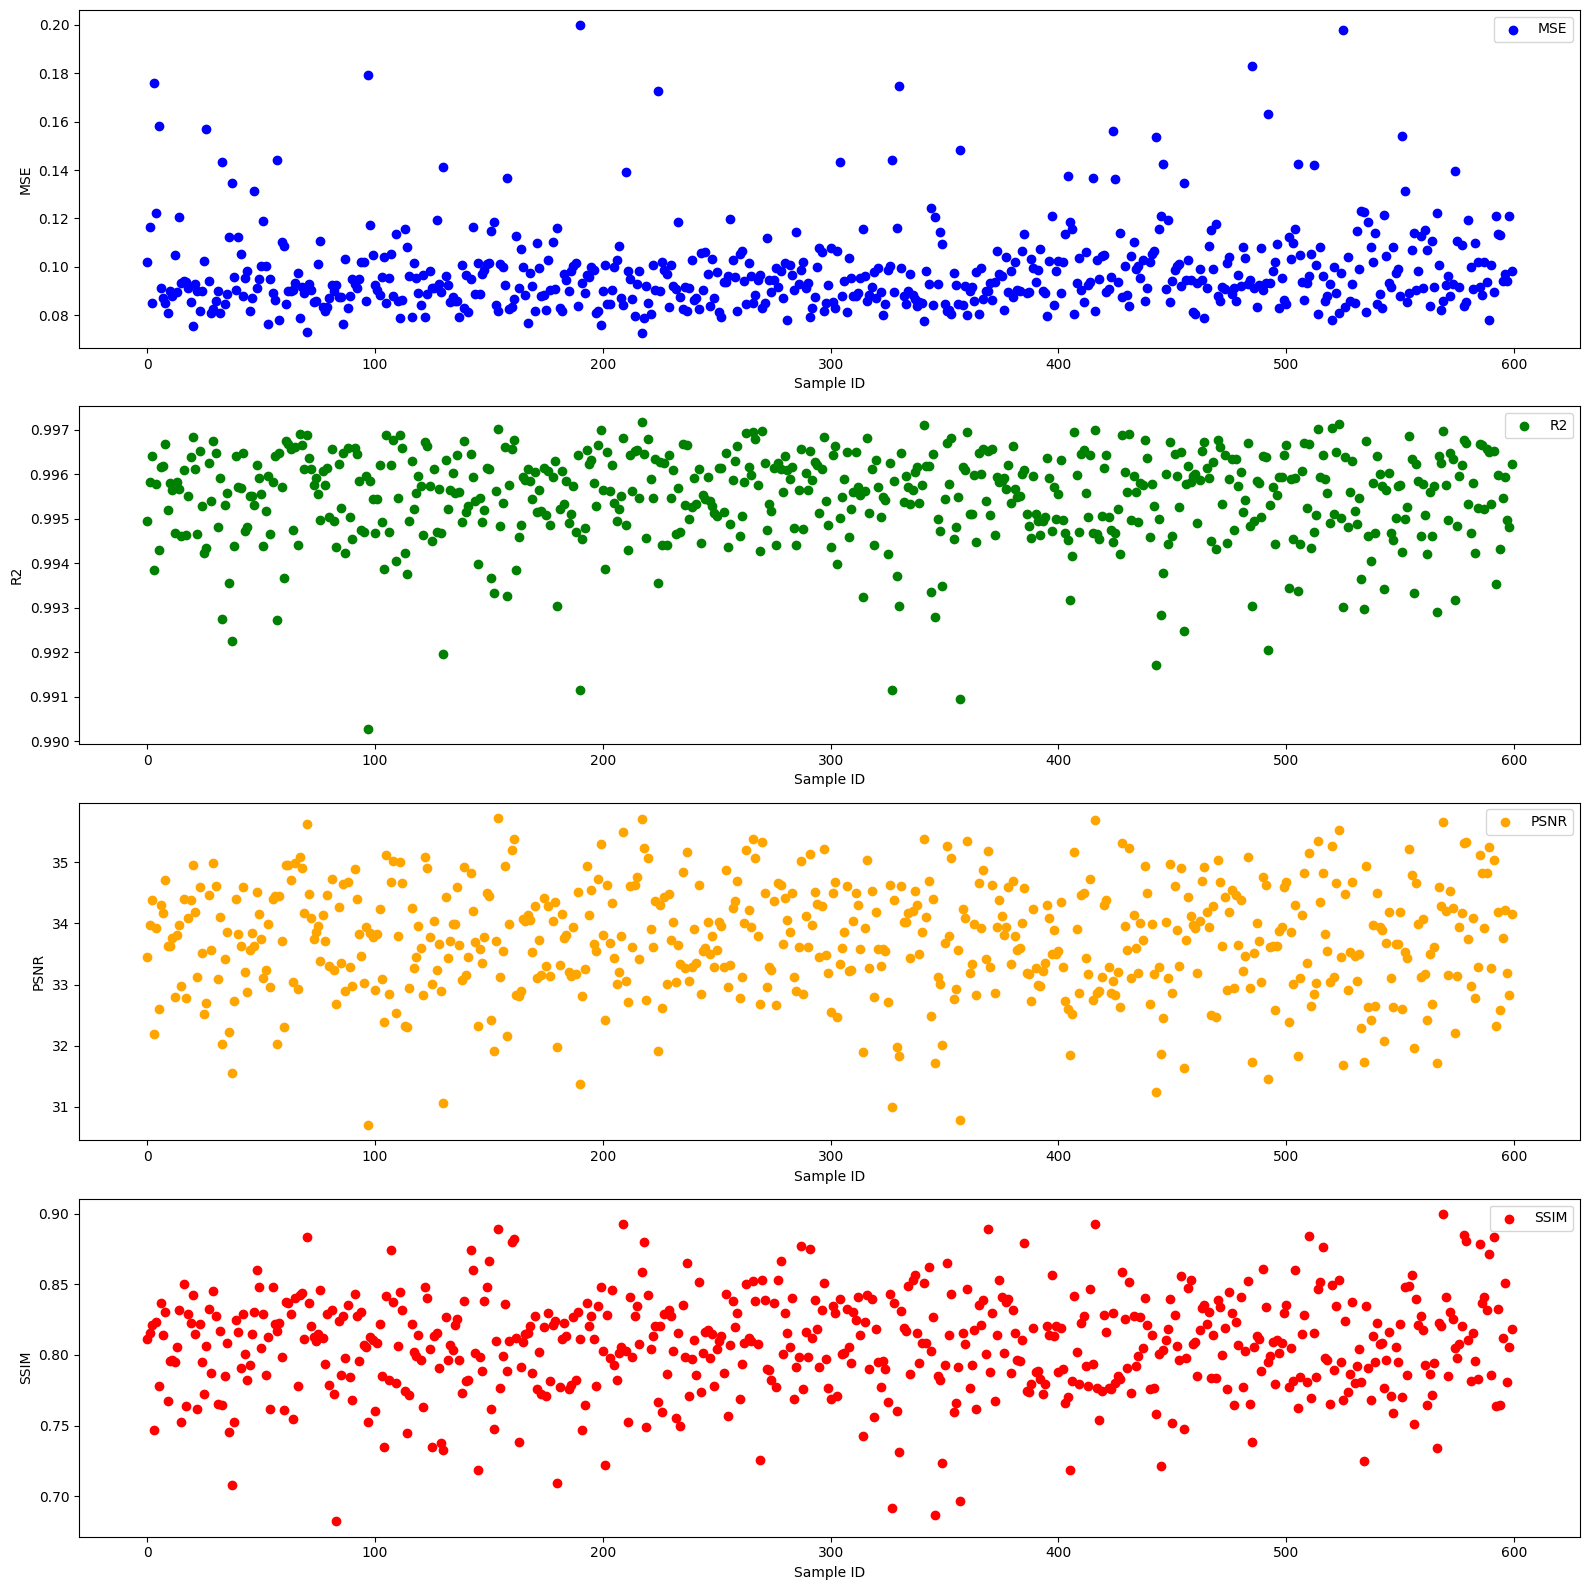

In [ ]:
#test results of each test sample
unique_sample_ids = df_validate['Sample ID'].unique()
fig, axs = plt.subplots(4, 1, figsize=(16, 16))
colors = ['blue', 'green', 'orange', 'red']
mse_list = []
r2_list = []
psnr_list = []
ssim_list = []

for i, sample_id in enumerate(unique_sample_ids):
    filtered = df_validate[df_validate['Sample ID'] == sample_id]
    X_sample_test = filtered.drop(columns=['I_q', 'Sample ID'])
    y_sample_test = filtered['I_q']
    dmatrix_test = xgb.DMatrix(X_sample_test)
    predicted = loaded_model.predict(dmatrix_test)
    #calculate r2 Score
    r2_score_ = r2_score(y_sample_test, predicted)
    #calculate mse
    mse_ = mean_squared_error(y_sample_test, predicted)
    predicted_matrix = np.reshape(predicted, (126, 37))
    original_matrix = np.reshape(y_sample_test.to_numpy(), (126, 37))
    range_ = np.max(y_sample_test) - np.min(predicted)
    #calculate psnr
    psnr_ = skimage.metrics.peak_signal_noise_ratio(original_matrix, predicted_matrix, data_range=range_)
    #calculate ssim
    ssim_ = skimage.metrics.structural_similarity(original_matrix, predicted_matrix, data_range=range_)

    # Append scores to lists
    mse_list.append(mse_)
    r2_list.append(r2_score_)
    psnr_list.append(psnr_)
    ssim_list.append(ssim_)

# Scatter plots for each score
axs[0].scatter(range(len(unique_sample_ids)), mse_list, color=colors[0])
axs[1].scatter(range(len(unique_sample_ids)), r2_list, color=colors[1])
axs[2].scatter(range(len(unique_sample_ids)), psnr_list, color=colors[2])
axs[3].scatter(range(len(unique_sample_ids)), ssim_list, color=colors[3])

# Set labels
for ax in axs:
    ax.set_xlabel('Sample ID')

axs[0].set_ylabel('MSE')
axs[1].set_ylabel('R2')
axs[2].set_ylabel('PSNR')
axs[3].set_ylabel('SSIM')

# Add legend outside the loop
axs[0].legend(['MSE'], loc='upper right')
axs[1].legend(['R2'], loc='upper right')
axs[2].legend(['PSNR'], loc='upper right')
axs[3].legend(['SSIM'], loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()


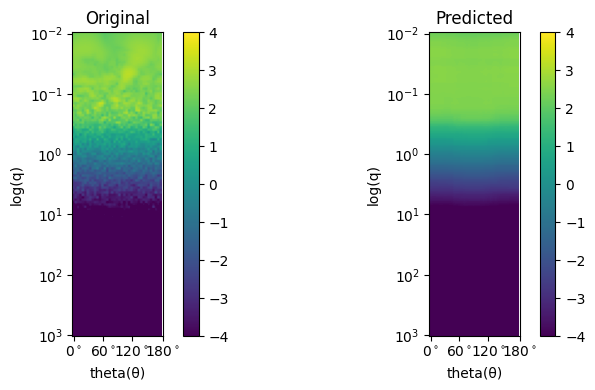

In [ ]:
#Predicting sample 224 and plotting the results
filtered = df_validate[df_validate['Sample ID'] == 224]
X_sample_test = filtered.drop(columns=['I_q', 'Sample ID']).to_numpy()
y_sample_test = filtered['I_q']
predicted = final_xgb.predict(X_sample_test)
r2_score_= r2_score(y_sample_test,predicted)
predicted_matrix = np.reshape(predicted, (126,37))
original_matrix = np.reshape(y_sample_test.to_numpy(), (126,37))
mse = mean_squared_error(y_sample_test, predicted)
range_ = np.max(y_sample_test) - np.min(predicted)
psnr_ = skimage.metrics.peak_signal_noise_ratio(original_matrix, predicted_matrix,data_range=range_)
ssim_ = skimage.metrics.structural_similarity(original_matrix, predicted_matrix,data_range=range_)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
# Plotting the first image
im1 = ax1.imshow(original_matrix, cmap='viridis', vmin=-4, vmax=4)
x_positions = [0,12,24,37]
x_ticks = ["0$^\circ$", "60$^\circ$", "120$^\circ$", "180$^\circ$"]
y_positions = [0,25,50,75,100,125]
y_ticks = ["$10^{-2}$", "$10^{-1}$", "$10^0$", "$10^1$", "$10^2$", "$10^3$"]
ax1.set_xticks(x_positions,x_ticks)
ax1.set_yticks(y_positions,y_ticks)
ax1.set_title('Original')
ax1.set_xlabel("theta(θ)")
ax1.set_ylabel("log(q)")
cbar1 = fig.colorbar(im1, ax=ax1)
# Plotting the second image
im2 = ax2.imshow(predicted_matrix, cmap='viridis', vmin=-4, vmax=4)
ax2.set_xticks(x_positions,x_ticks)
ax2.set_yticks(y_positions,y_ticks)
ax2.set_title('Predicted')
ax2.set_xlabel("theta(θ)")
ax2.set_ylabel("log(q)")
cbar2 = fig.colorbar(im2, ax=ax2)
plt.tight_layout()
#fig.savefig('test_sample_224_2D.svg', format='svg')

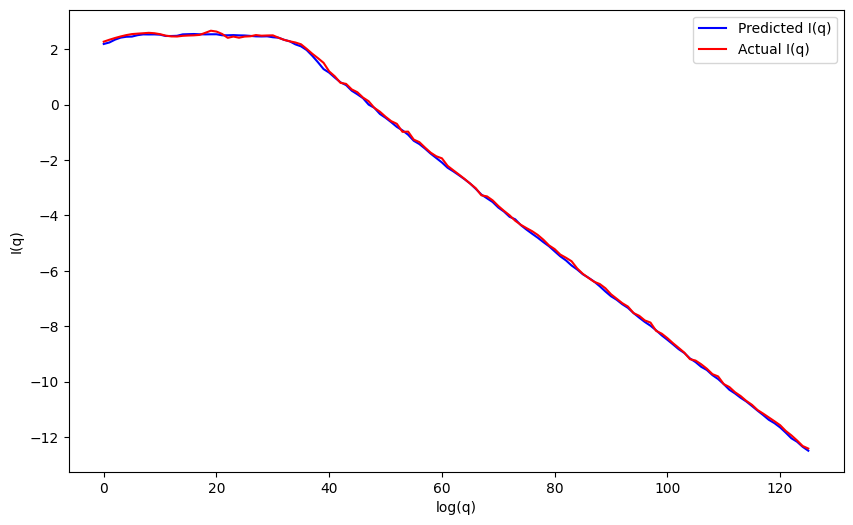

Mean Squared Error image: 0.0877908016976975
R-squared image: 0.996474728470015
PSNR: 34.59909313915547
SSIM: 0.8287759994403567


In [ ]:
#comparing the azimuthal 1D plot of sample 224
f_array_pred = np.reshape(predicted, (126, 37))
f_array_actual = np.reshape(np.array(y_sample_test), (126, 37))

average_pred = np.mean(f_array_pred, axis=1)
average_actual = np.mean(f_array_actual, axis=1)
plt.figure(figsize=(10, 6))
plt.xlabel("log(q)")
plt.ylabel("I(q)")
#plt.title("Average Predictions vs. Average Actual")
plt.plot(average_pred, label="Predicted I(q)", color="blue", linestyle="-")
plt.plot(average_actual, label="Actual I(q)", color="red", linestyle="-")
plt.legend()
fig = plt.gcf()
fig.savefig('least_test_sample_1609_1D.svg', format='svg')
plt.show()
print("Mean Squared Error image:", mse)
print("R-squared image:", r2_score_)
print('PSNR:',psnr_3_1)
print('SSIM:', ssim_3_1)

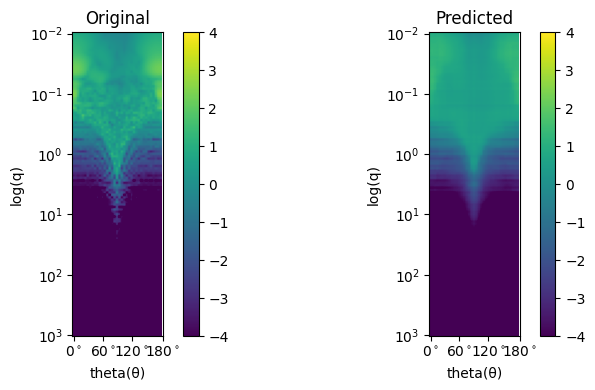

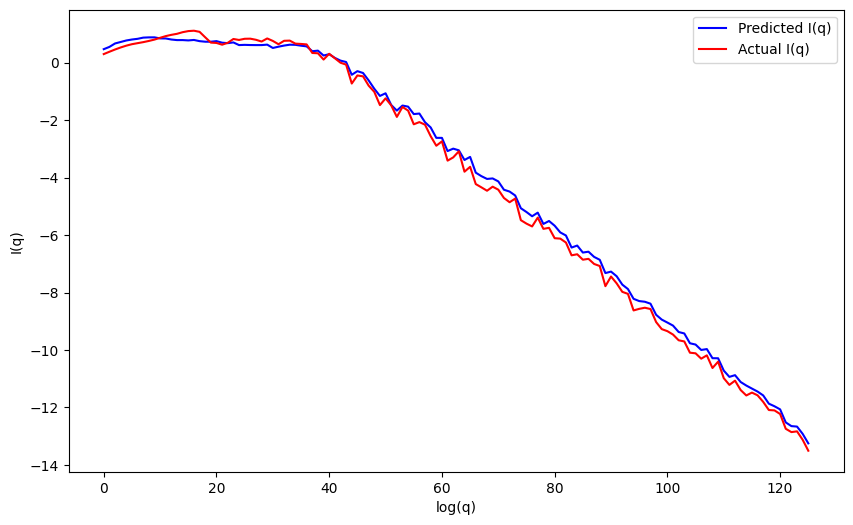

Mean Squared Error image: 0.19977128631632873
R-squared image: 0.9911481838728253
PSNR: 31.381626712742438
SSIM: 0.8115520306870495


In [ ]:
#test sample 978 with 2D and 1D predicted profiles
filtered = df_validate[df_validate['Sample ID'] == 978]
X_sample_test = filtered.drop(columns=['I_q', 'Sample ID']).to_numpy()
y_sample_test = filtered['I_q']
predicted = final_xgb.predict(X_sample_test)
r2_score_= r2_score(y_sample_test,predicted)
predicted_matrix = np.reshape(predicted, (126,37))
original_matrix = np.reshape(y_sample_test.to_numpy(), (126,37))
mse = mean_squared_error(y_sample_test, predicted)
range_3_1 = np.max(y_sample_test) - np.min(predicted)
psnr_3_1 = skimage.metrics.peak_signal_noise_ratio(original_matrix, predicted_matrix,data_range=range_3_1)
ssim_3_1 = skimage.metrics.structural_similarity(original_matrix, predicted_matrix,data_range=range_3_1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
# Plotting the first image
im1 = ax1.imshow(original_matrix, cmap='viridis', vmin=-4, vmax=4)
x_positions = [0,12,24,37]
x_ticks = ["0$^\circ$", "60$^\circ$", "120$^\circ$", "180$^\circ$"]
y_positions = [0,25,50,75,100,125]
y_ticks = ["$10^{-2}$", "$10^{-1}$", "$10^0$", "$10^1$", "$10^2$", "$10^3$"]
ax1.set_xticks(x_positions,x_ticks)
ax1.set_yticks(y_positions,y_ticks)
ax1.set_title('Original')
ax1.set_xlabel("theta(θ)")
ax1.set_ylabel("log(q)")
cbar1 = fig.colorbar(im1, ax=ax1)
# Plotting the second image
im2 = ax2.imshow(predicted_matrix, cmap='viridis', vmin=-4, vmax=4)
ax2.set_xticks(x_positions,x_ticks)
ax2.set_yticks(y_positions,y_ticks)
ax2.set_title('Predicted')
ax2.set_xlabel("theta(θ)")
ax2.set_ylabel("log(q)")
cbar2 = fig.colorbar(im2, ax=ax2)
plt.tight_layout()
#fig.savefig('least_test_sample_1609_2D.svg', format='svg')
f_array_pred = np.reshape(predicted, (126, 37))
f_array_actual = np.reshape(np.array(y_sample_test), (126, 37))

average_pred = np.mean(f_array_pred, axis=1)
average_actual = np.mean(f_array_actual, axis=1)
plt.figure(figsize=(10, 6))
plt.xlabel("log(q)")
plt.ylabel("I(q)")
#plt.title("Average Predictions vs. Average Actual")

plt.plot(average_pred, label="Predicted I(q)", color="blue", linestyle="-")
plt.plot(average_actual, label="Actual I(q)", color="red", linestyle="-")
plt.legend()
fig = plt.gcf()
fig.savefig('least_test_sample_1609_1D.svg', format='svg')
plt.show()
print("Mean Squared Error image:", mse)
print("R-squared image:", r2_score_)
print('PSNR:',psnr_3_1)
print('SSIM:', ssim_3_1)

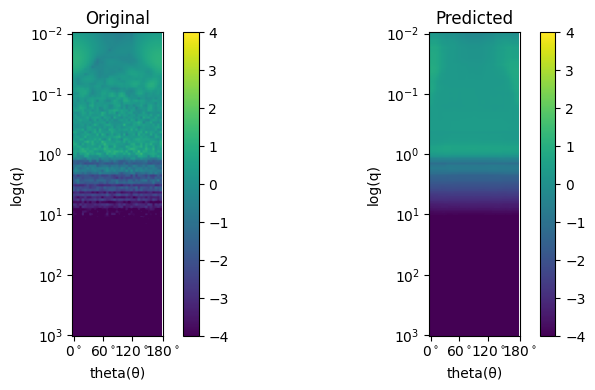

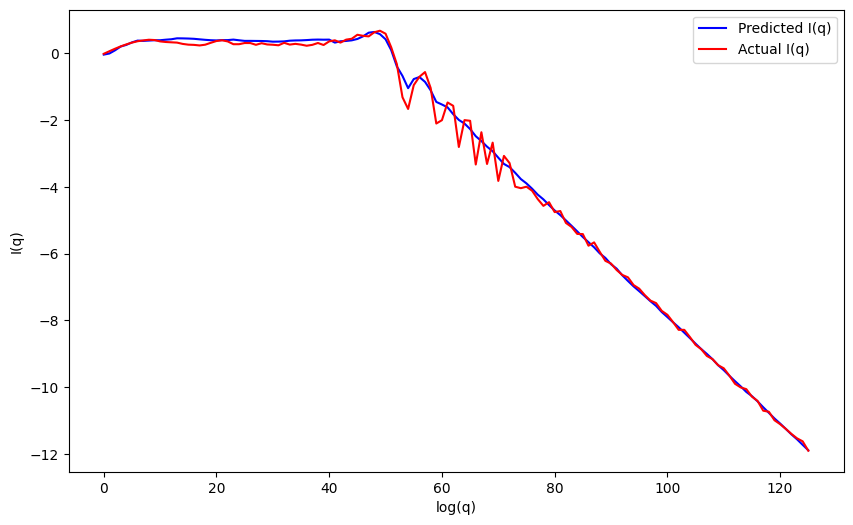

Mean Squared Error image: 0.1204842473845067
R-squared image: 0.9927995234500872
PSNR: 31.723781317798903
SSIM: 0.6867638596946976


In [ ]:
#Test Sample 1853 with 2D and 1D predicted profiles
filtered = df_validate[df_validate['Sample ID'] == 1853]
X_sample_test = filtered.drop(columns=['I_q', 'Sample ID']).to_numpy()
y_sample_test = filtered['I_q']
predicted = final_xgb.predict(X_sample_test)
r2_score_= r2_score(y_sample_test,predicted)
predicted_matrix = np.reshape(predicted, (126,37))
original_matrix = np.reshape(y_sample_test.to_numpy(), (126,37))
mse = mean_squared_error(y_sample_test, predicted)
range_3_1 = np.max(y_sample_test) - np.min(predicted)
psnr_3_1 = skimage.metrics.peak_signal_noise_ratio(original_matrix, predicted_matrix,data_range=range_3_1)
ssim_3_1 = skimage.metrics.structural_similarity(original_matrix, predicted_matrix,data_range=range_3_1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
# Plotting the first image
im1 = ax1.imshow(original_matrix, cmap='viridis', vmin=-4, vmax=4)
x_positions = [0,12,24,37]
x_ticks = ["0$^\circ$", "60$^\circ$", "120$^\circ$", "180$^\circ$"]
y_positions = [0,25,50,75,100,125]
y_ticks = ["$10^{-2}$", "$10^{-1}$", "$10^0$", "$10^1$", "$10^2$", "$10^3$"]
ax1.set_xticks(x_positions,x_ticks)
ax1.set_yticks(y_positions,y_ticks)
ax1.set_title('Original')
ax1.set_xlabel("theta(θ)")
ax1.set_ylabel("log(q)")
cbar1 = fig.colorbar(im1, ax=ax1)
# Plotting the second image
im2 = ax2.imshow(predicted_matrix, cmap='viridis', vmin=-4, vmax=4)
ax2.set_xticks(x_positions,x_ticks)
ax2.set_yticks(y_positions,y_ticks)
ax2.set_title('Predicted')
ax2.set_xlabel("theta(θ)")
ax2.set_ylabel("log(q)")
cbar2 = fig.colorbar(im2, ax=ax2)
plt.tight_layout()
#fig.savefig('least_test_sample_1609_2D.svg', format='svg')
f_array_pred = np.reshape(predicted, (126, 37))
f_array_actual = np.reshape(np.array(y_sample_test), (126, 37))

average_pred = np.mean(f_array_pred, axis=1)
average_actual = np.mean(f_array_actual, axis=1)
plt.figure(figsize=(10, 6))
plt.xlabel("log(q)")
plt.ylabel("I(q)")
#plt.title("Average Predictions vs. Average Actual")

plt.plot(average_pred, label="Predicted I(q)", color="blue", linestyle="-")
plt.plot(average_actual, label="Actual I(q)", color="red", linestyle="-")
plt.legend()
fig = plt.gcf()
fig.savefig('least_test_sample_1609_1D.svg', format='svg')
plt.show()
print("Mean Squared Error image:", mse)
print("R-squared image:", r2_score_)
print('PSNR:',psnr_3_1)
print('SSIM:', ssim_3_1)

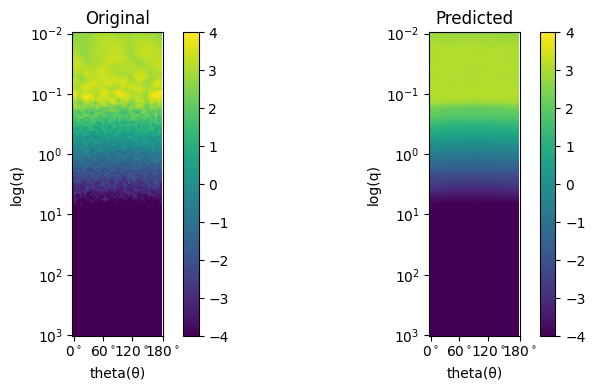

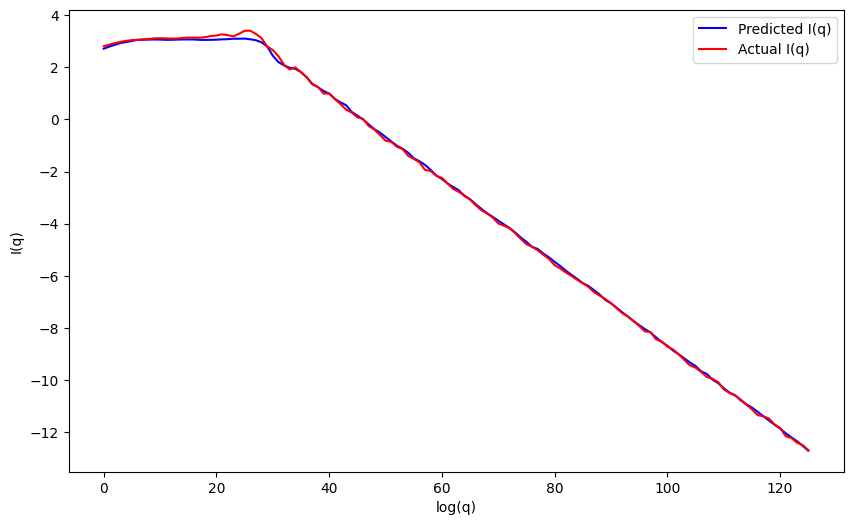

Mean Squared Error image: 0.07396523161315009
R-squared image: 0.9972968673057976
PSNR: 35.77552936599598
SSIM: 0.8656094771120145


In [ ]:
#test sample 214 with 2D and 1D predicted profiles
filtered = df_validate[df_validate['Sample ID'] == 214]
X_sample_test = filtered.drop(columns=['I_q', 'Sample ID'])
y_sample_test = filtered['I_q']
dmatrix_test = xgb.DMatrix(X_sample_test)
predicted = loaded_model.predict(dmatrix_test)
r2_score_= r2_score(y_sample_test,predicted)
predicted_matrix = np.reshape(predicted, (126,37))
original_matrix = np.reshape(y_sample_test.to_numpy(), (126,37))
mse = mean_squared_error(y_sample_test, predicted)
range_3_1 = np.max(y_sample_test) - np.min(predicted)
psnr_3_1 = skimage.metrics.peak_signal_noise_ratio(original_matrix, predicted_matrix,data_range=range_3_1)
ssim_3_1 = skimage.metrics.structural_similarity(original_matrix, predicted_matrix,data_range=range_3_1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
# Plotting the first image
im1 = ax1.imshow(original_matrix, cmap='viridis', vmin=-4, vmax=4)
x_positions = [0,12,24,37]
x_ticks = ["0$^\circ$", "60$^\circ$", "120$^\circ$", "180$^\circ$"]
y_positions = [0,25,50,75,100,125]
y_ticks = ["$10^{-2}$", "$10^{-1}$", "$10^0$", "$10^1$", "$10^2$", "$10^3$"]
ax1.set_xticks(x_positions,x_ticks)
ax1.set_yticks(y_positions,y_ticks)
ax1.set_title('Original')
ax1.set_xlabel("theta(θ)")
ax1.set_ylabel("log(q)")
cbar1 = fig.colorbar(im1, ax=ax1)
# Plotting the second image
im2 = ax2.imshow(predicted_matrix, cmap='viridis', vmin=-4, vmax=4)
ax2.set_xticks(x_positions,x_ticks)
ax2.set_yticks(y_positions,y_ticks)
ax2.set_title('Predicted')
ax2.set_xlabel("theta(θ)")
ax2.set_ylabel("log(q)")
cbar2 = fig.colorbar(im2, ax=ax2)
plt.tight_layout()
#fig.savefig('least_test_sample_1609_2D.svg', format='svg')
f_array_pred = np.reshape(predicted, (126, 37))
f_array_actual = np.reshape(np.array(y_sample_test), (126, 37))

average_pred = np.mean(f_array_pred, axis=1)
average_actual = np.mean(f_array_actual, axis=1)
plt.figure(figsize=(10, 6))
plt.xlabel("log(q)")
plt.ylabel("I(q)")
#plt.title("Average Predictions vs. Average Actual")

plt.plot(average_pred, label="Predicted I(q)", color="blue", linestyle="-")
plt.plot(average_actual, label="Actual I(q)", color="red", linestyle="-")
plt.legend()
fig = plt.gcf()
fig.savefig('least_test_sample_1609_1D.svg', format='svg')
plt.show()
print("Mean Squared Error image:", mse)
print("R-squared image:", r2_score_)
print('PSNR:',psnr_3_1)
print('SSIM:', ssim_3_1)